In [1]:
# !pip install torch==2.2.0
# !pip install torchtext==0.17.2
# !pip install torchdata==0.7.1
# !pip install transformers==4.35.2
# !pip install seaborn

In [2]:
import os
os.chdir("..")

In [12]:
from src.dataloader import get_dataloaders
from src.model import CustomGPTModel
from src.engine import train_one_epoch, evaluate
from src.utils import generate_text, setup_logging
from src.config import *

import torch
import torch.nn as nn
import time

import matplotlib.pyplot as plt
from typing import List

In [4]:
EXPERIMENT_DIR = 'runs/epoch_1_30'
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
best_model_path = os.path.join(EXPERIMENT_DIR, "best_model.pth")
checkpoint_path = os.path.join(EXPERIMENT_DIR, "latest_checkpoint.pth")
log_file_path = os.path.join(EXPERIMENT_DIR, "training.log")

In [5]:
logger = setup_logging(log_file_path)

In [6]:
train_dataloader, val_dataloader, test_dataloader, vocab = get_dataloaders(
    processed_data_path=PROCESSED_DATA_PATH,
    vocab_path=VOCAB_PATH,
    tokenizer=tokenizer,
    block_size=BLOCK_SIZE,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    PAD_IDX=PAD_IDX,
    END_OF_TEXT_TOKEN=END_OF_TEXT_TOKEN
)

Loading pre-processed data and vocabulary...
Vocabulary Size: 39270
Loading complete.

--- Inspecting a single batch from the train_dataloader ---
Shape of the source (src) batch:	torch.Size([64, 64]) -> [sequence_length, batch_size]
Shape of the target (tgt) batch:	torch.Size([64, 64]) -> [sequence_length, batch_size]

--- Inspecting the first example in the batch ---
Shape of a single source example:	torch.Size([64])

Decoded Source (Input to Model):
'however for the viewer who sits through this nonsensical trash there is absolutely nothing to love about this movieyou havent seen dysfunctional families until youve seen this bunch pa is crazy ma is crazy the son is crazy and the daughter is oh yeah crazy they also have mouths on them that utter words that would make a sailor blush especially the teenage <unk>'

Decoded Target (What Model Predicts):
'for the viewer who sits through this nonsensical trash there is absolutely nothing to love about this movieyou havent seen dysfunctional 

In [7]:
VOCAB_SIZE = len(vocab)

In [8]:
VOCAB_SIZE

39270

In [9]:
model = CustomGPTModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    max_seq_len=BLOCK_SIZE
).to(DEVICE)

loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

NUM_EPOCHS = 30 
total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.0003, 
    total_steps=total_steps,
    pct_start=0.1,    
    anneal_strategy='cos'
)

In [10]:
train_losses, train_accuracies, train_perplexities = [], [], []
val_losses, val_accuracies, val_perplexities = [], [], []

start_epoch = 1
best_val_loss = float('inf')

logger.info(f"Starting training for {NUM_EPOCHS} epochs on device: {DEVICE}")

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss, train_acc, train_ppl = train_one_epoch(model, train_dataloader, loss_fn, optimizer, scheduler, DEVICE)
    val_loss, val_acc, val_ppl = evaluate(model, val_dataloader, loss_fn, DEVICE)
    
    epoch_duration = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_perplexities.append(train_ppl)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_perplexities.append(val_ppl)

    log_message = (
    f"| Epoch {epoch:3d}/{NUM_EPOCHS:3d} | Time: {epoch_duration:5.2f}s | LR: {current_lr:.6f} | "
    f"Train Loss: {train_loss:5.3f}, PPL: {train_ppl:8.2f}, Acc: {train_acc*100:5.2f}% | "
    f"Val Loss: {val_loss:5.3f}, PPL: {val_ppl:8.2f}, Acc: {val_acc*100:5.2f}% |"
    )
    logger.info(log_message)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        logger.info(f"-> New best model saved to '{best_model_path}' with validation loss: {best_val_loss:.3f}")


    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'train_perplexities': train_perplexities,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_perplexities': val_perplexities
        
    }, checkpoint_path)

2025-08-15 16:13:12,291 - INFO - Starting training for 30 epochs on device: cuda


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.57it/s]

2025-08-15 16:13:50,998 - INFO - | Epoch   1/ 30 | Time: 38.71s | LR: 0.000084 | Train Loss: 8.691, PPL:  5947.41, Acc:  5.70% | Val Loss: 6.826, PPL:   921.06, Acc:  5.88% |


2025-08-15 16:13:51,394 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 6.826


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.99it/s]

2025-08-15 16:14:30,789 - INFO - | Epoch   2/ 30 | Time: 38.39s | LR: 0.000228 | Train Loss: 6.274, PPL:   530.75, Acc: 11.39% | Val Loss: 5.842, PPL:   344.30, Acc: 14.06% |


2025-08-15 16:14:31,287 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.842


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.82it/s]

2025-08-15 16:15:11,104 - INFO - | Epoch   3/ 30 | Time: 38.50s | LR: 0.000300 | Train Loss: 5.733, PPL:   308.92, Acc: 14.84% | Val Loss: 5.536, PPL:   253.70, Acc: 16.00% |


2025-08-15 16:15:11,615 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.536


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.09it/s]

2025-08-15 16:15:51,448 - INFO - | Epoch   4/ 30 | Time: 38.50s | LR: 0.000299 | Train Loss: 5.488, PPL:   241.75, Acc: 16.24% | Val Loss: 5.370, PPL:   214.94, Acc: 16.95% |


2025-08-15 16:15:51,970 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.370


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.90it/s]

2025-08-15 16:16:31,669 - INFO - | Epoch   5/ 30 | Time: 38.35s | LR: 0.000296 | Train Loss: 5.323, PPL:   204.95, Acc: 17.19% | Val Loss: 5.276, PPL:   195.57, Acc: 17.55% |


2025-08-15 16:16:32,210 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.276


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.31it/s]

2025-08-15 16:17:12,097 - INFO - | Epoch   6/ 30 | Time: 38.54s | LR: 0.000291 | Train Loss: 5.207, PPL:   182.48, Acc: 17.87% | Val Loss: 5.212, PPL:   183.49, Acc: 18.13% |


2025-08-15 16:17:12,607 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.212


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.13it/s]

2025-08-15 16:17:52,181 - INFO - | Epoch   7/ 30 | Time: 38.29s | LR: 0.000284 | Train Loss: 5.112, PPL:   165.96, Acc: 18.42% | Val Loss: 5.151, PPL:   172.55, Acc: 18.50% |


2025-08-15 16:17:52,684 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.151


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.90it/s]

2025-08-15 16:18:32,259 - INFO - | Epoch   8/ 30 | Time: 38.31s | LR: 0.000275 | Train Loss: 5.038, PPL:   154.20, Acc: 18.81% | Val Loss: 5.119, PPL:   167.24, Acc: 18.82% |


2025-08-15 16:18:32,771 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.119


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.89it/s]

2025-08-15 16:19:12,551 - INFO - | Epoch   9/ 30 | Time: 38.41s | LR: 0.000265 | Train Loss: 4.970, PPL:   144.07, Acc: 19.22% | Val Loss: 5.079, PPL:   160.68, Acc: 19.16% |


2025-08-15 16:19:13,076 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.079


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.25it/s]

2025-08-15 16:19:52,753 - INFO - | Epoch  10/ 30 | Time: 38.32s | LR: 0.000253 | Train Loss: 4.909, PPL:   135.44, Acc: 19.54% | Val Loss: 5.074, PPL:   159.79, Acc: 19.12% |


2025-08-15 16:19:53,310 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.074


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.65it/s]

2025-08-15 16:20:32,991 - INFO - | Epoch  11/ 30 | Time: 38.30s | LR: 0.000240 | Train Loss: 4.858, PPL:   128.83, Acc: 19.82% | Val Loss: 5.059, PPL:   157.36, Acc: 19.33% |


2025-08-15 16:20:33,520 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.059


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.34it/s]

2025-08-15 16:21:13,292 - INFO - | Epoch  12/ 30 | Time: 38.39s | LR: 0.000225 | Train Loss: 4.806, PPL:   122.27, Acc: 20.20% | Val Loss: 5.040, PPL:   154.41, Acc: 19.51% |


2025-08-15 16:21:13,819 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.040


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.04it/s]

2025-08-15 16:21:53,582 - INFO - | Epoch  13/ 30 | Time: 38.35s | LR: 0.000209 | Train Loss: 4.764, PPL:   117.21, Acc: 20.42% | Val Loss: 5.029, PPL:   152.73, Acc: 19.55% |


2025-08-15 16:21:54,083 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.029


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.39it/s]

2025-08-15 16:22:33,710 - INFO - | Epoch  14/ 30 | Time: 38.40s | LR: 0.000193 | Train Loss: 4.729, PPL:   113.14, Acc: 20.63% | Val Loss: 5.031, PPL:   153.12, Acc: 19.72% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.14it/s]

2025-08-15 16:23:13,582 - INFO - | Epoch  15/ 30 | Time: 38.39s | LR: 0.000176 | Train Loss: 4.690, PPL:   108.88, Acc: 20.89% | Val Loss: 5.022, PPL:   151.70, Acc: 19.80% |


2025-08-15 16:23:14,126 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.022


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.95it/s]

2025-08-15 16:23:53,824 - INFO - | Epoch  16/ 30 | Time: 38.39s | LR: 0.000159 | Train Loss: 4.661, PPL:   105.72, Acc: 21.10% | Val Loss: 5.023, PPL:   151.85, Acc: 19.75% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.02it/s]

2025-08-15 16:24:33,448 - INFO - | Epoch  17/ 30 | Time: 38.32s | LR: 0.000141 | Train Loss: 4.631, PPL:   102.62, Acc: 21.30% | Val Loss: 5.015, PPL:   150.67, Acc: 19.90% |


2025-08-15 16:24:33,979 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.015


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.54it/s]

2025-08-15 16:25:13,490 - INFO - | Epoch  18/ 30 | Time: 38.30s | LR: 0.000124 | Train Loss: 4.603, PPL:    99.75, Acc: 21.47% | Val Loss: 5.008, PPL:   149.66, Acc: 19.91% |


2025-08-15 16:25:14,016 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.008


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.02it/s]

2025-08-15 16:25:53,561 - INFO - | Epoch  19/ 30 | Time: 38.16s | LR: 0.000107 | Train Loss: 4.578, PPL:    97.34, Acc: 21.64% | Val Loss: 5.006, PPL:   149.30, Acc: 20.06% |


2025-08-15 16:25:54,122 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.006


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.00it/s]

2025-08-15 16:26:33,762 - INFO - | Epoch  20/ 30 | Time: 38.29s | LR: 0.000091 | Train Loss: 4.555, PPL:    95.09, Acc: 21.81% | Val Loss: 5.005, PPL:   149.18, Acc: 19.97% |


2025-08-15 16:26:34,303 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 5.005


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.01it/s]

2025-08-15 16:27:13,815 - INFO - | Epoch  21/ 30 | Time: 38.28s | LR: 0.000075 | Train Loss: 4.535, PPL:    93.21, Acc: 21.97% | Val Loss: 4.994, PPL:   147.48, Acc: 20.16% |


2025-08-15 16:27:14,337 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 4.994


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s]

2025-08-15 16:27:54,082 - INFO - | Epoch  22/ 30 | Time: 38.40s | LR: 0.000060 | Train Loss: 4.518, PPL:    91.68, Acc: 22.10% | Val Loss: 5.000, PPL:   148.43, Acc: 20.07% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.91it/s]

2025-08-15 16:28:33,857 - INFO - | Epoch  23/ 30 | Time: 38.48s | LR: 0.000047 | Train Loss: 4.507, PPL:    90.66, Acc: 22.22% | Val Loss: 4.994, PPL:   147.57, Acc: 20.15% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.93it/s]

2025-08-15 16:29:13,689 - INFO - | Epoch  24/ 30 | Time: 38.54s | LR: 0.000035 | Train Loss: 4.493, PPL:    89.41, Acc: 22.30% | Val Loss: 5.004, PPL:   148.97, Acc: 20.16% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.13it/s]

2025-08-15 16:29:53,645 - INFO - | Epoch  25/ 30 | Time: 38.60s | LR: 0.000025 | Train Loss: 4.483, PPL:    88.51, Acc: 22.38% | Val Loss: 5.002, PPL:   148.69, Acc: 20.18% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.81it/s]

2025-08-15 16:30:33,954 - INFO - | Epoch  26/ 30 | Time: 38.91s | LR: 0.000016 | Train Loss: 4.475, PPL:    87.82, Acc: 22.45% | Val Loss: 5.004, PPL:   148.98, Acc: 20.15% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.02it/s]

2025-08-15 16:31:13,998 - INFO - | Epoch  27/ 30 | Time: 38.65s | LR: 0.000009 | Train Loss: 4.470, PPL:    87.39, Acc: 22.49% | Val Loss: 4.991, PPL:   147.07, Acc: 20.30% |


2025-08-15 16:31:14,569 - INFO - -> New best model saved to 'runs/epoch_1_30/best_model.pth' with validation loss: 4.991


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.01it/s]

2025-08-15 16:31:54,353 - INFO - | Epoch  28/ 30 | Time: 38.41s | LR: 0.000004 | Train Loss: 4.463, PPL:    86.79, Acc: 22.53% | Val Loss: 5.000, PPL:   148.35, Acc: 20.17% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.00it/s]

2025-08-15 16:32:33,947 - INFO - | Epoch  29/ 30 | Time: 38.39s | LR: 0.000001 | Train Loss: 4.465, PPL:    86.96, Acc: 22.55% | Val Loss: 4.996, PPL:   147.82, Acc: 20.32% |



Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.64it/s]

2025-08-15 16:33:13,585 - INFO - | Epoch  30/ 30 | Time: 38.31s | LR: 0.000000 | Train Loss: 4.464, PPL:    86.85, Acc: 22.58% | Val Loss: 4.998, PPL:   148.06, Acc: 20.14% |


In [13]:
def plot_history(
    train_losses: List[float],
    val_losses: List[float],
    train_accuracies: List[float],
    val_accuracies: List[float],
    train_perplexities: List[float],
    val_perplexities: List[float]
):
    """
    Plots the training and validation metrics over epochs.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # --- Subplot 1: Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # --- Subplot 2: Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # --- Subplot 3: Perplexity ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_perplexities, 'bo-', label='Training Perplexity')
    plt.plot(epochs, val_perplexities, 'ro-', label='Validation Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

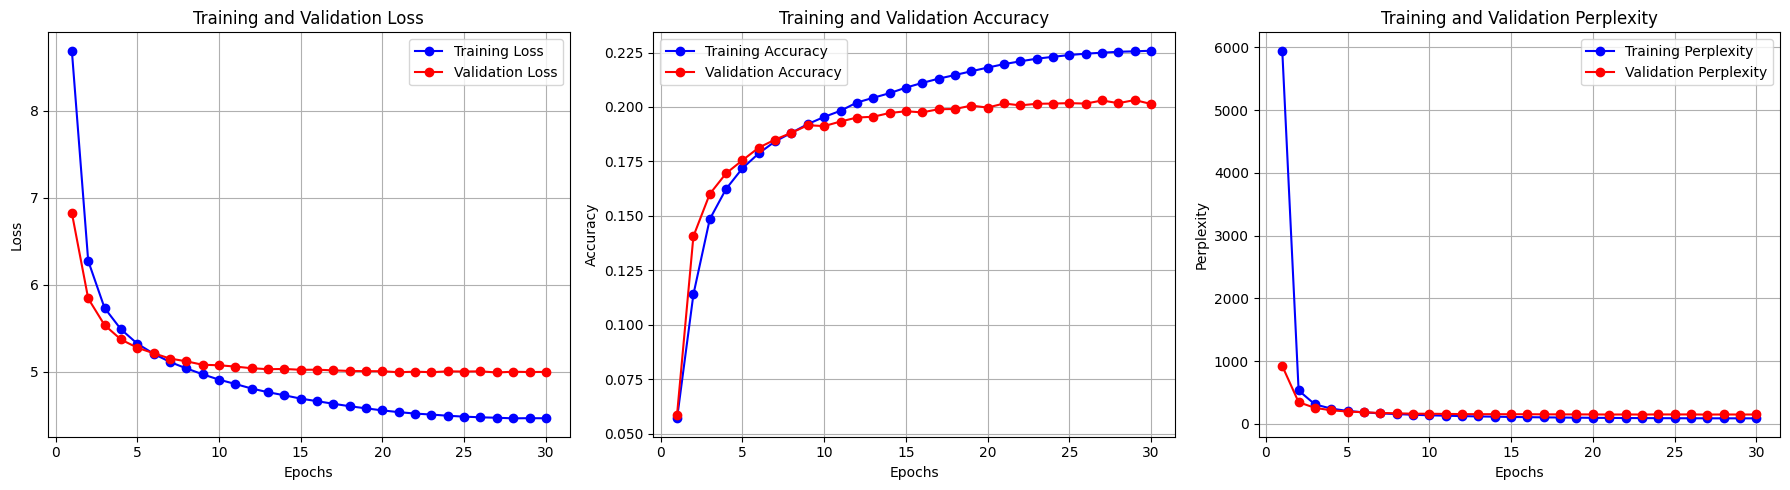

In [14]:
plot_history(
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    train_perplexities,
    val_perplexities
)

# checkpoint = torch.load(checkpoint_path)
# plot_history(
#     checkpoint['train_losses'],
#     checkpoint['val_losses'],
#     checkpoint['train_accuracies'],
#     checkpoint['val_accuracies'],
#     checkpoint['train_perplexities'],
#     checkpoint['val_perplexities']
# )

In [16]:
best_model_path

'runs/epoch_1_30/best_model.pth'

In [17]:
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model weights from '{best_model_path}' for inference.")
else:
    print("No best model found. Using the last trained model for inference.")

Loaded best model weights from 'runs/epoch_1_30/best_model.pth' for inference.


In [18]:
prompt = "I think this movie was"

# 3. Generate the text
print("\n--- Generating Text ---")
generated_text = generate_text(
    model=model,
    prompt=prompt,
    tokenizer=tokenizer,
    vocab=vocab,
    block_size=BLOCK_SIZE,
    max_new_tokens=100,  # Generate 100 new tokens
    device=DEVICE
)

# 4. Print the final result
print(f"\nPrompt: '{prompt}'")
print("-" * 50)
print(f"Generated Text:\n'{generated_text}'")
print("-" * 50)


--- Generating Text ---

Prompt: 'I think this movie was'
--------------------------------------------------
Generated Text:
'i think this movie was a great movie i have seen it in a long time and i have to say that it was a great movie i have seen it times and i have seen it times and i have to say that i have seen it times and i have to say that i have seen it times and i have to say that it is a great movie i have seen it again and again and again and again and again i recommend it to anyone who likes it and if you are a fan of the original and i recommend it'
--------------------------------------------------


In [20]:
model.eval()

prompts_to_test = [
    "This is one of the best films I have ever seen.",
    "The plot was full of holes and the characters were",
    "The story is about a young detective who discovers",
    "That one scene with the car was just"
]

print("--- Starting Batch Generation ---")

for prompt in prompts_to_test:
    generated_text = generate_text(
        model=model,
        prompt=prompt,
        tokenizer=tokenizer,
        vocab=vocab,
        block_size=BLOCK_SIZE,
        max_new_tokens=50,  # Generate 50 new tokens for each prompt
        device=DEVICE
    )
    
    print("-" * 80)
    print(f"PROMPT: '{prompt}'")
    print(f"\nGENERATED: '{generated_text}'\n")

print("--- Batch Generation Complete ---")

--- Starting Batch Generation ---
--------------------------------------------------------------------------------
PROMPT: 'This is one of the best films I have ever seen.'

GENERATED: 'this is one of the best films i have ever seen <unk> is a great film and i have seen it times and i have seen it times and i have to say that it is a great movie i have seen it times and i have to say that it is a great movie and i recommend it to anyone who'

--------------------------------------------------------------------------------
PROMPT: 'The plot was full of holes and the characters were'

GENERATED: 'the plot was full of holes and the characters were not developed and the characters were not developed and the characters were not developed and the story was not developed and the characters were not developed and the story was not developed and the characters were not developed and the story was not very interesting and the story was very'

-----------------------------------------------------